In [1]:
#STEP:1
#IMPORTING LIBRARIES
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
#STEP 2: LOADING THE DATA

df = pd.read_csv("food_delivery_time.csv")

#lets see the data
print("Dataset Shape:",df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\n Column names")
print(df.columns.tolist())

Dataset Shape: (45593, 20)

First 5 rows:
        ID Delivery_person_ID Delivery_person_Age Delivery_person_Ratings  \
0  0x4607     INDORES13DEL02                   37                     4.9   
1  0xb379     BANGRES18DEL02                   34                     4.5   
2  0x5d6d     BANGRES19DEL01                   23                     4.4   
3  0x7a6a    COIMBRES13DEL02                   38                     4.7   
4  0x70a2     CHENRES12DEL01                   32                     4.6   

   Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
0            22.745049             75.892471                   22.765049   
1            12.913041             77.683237                   13.043041   
2            12.914264             77.678400                   12.924264   
3            11.003669             76.976494                   11.053669   
4            12.972793             80.249982                   13.012793   

   Delivery_location_longitude  Order_

In [3]:
#STEP 3 CLEANING DATA

df= df.replace('NaN ',np.nan)

#CHECK FOR MISSING VALUES
print("\nMissing Values:")
print(df.isnull().sum())

#GET STATISTICS
print("\nData Summary:")
print(df.describe())

#check data type
print("\nData Types:")
print(df.dtypes)



Missing Values:
ID                                0
Delivery_person_ID                0
Delivery_person_Age            1854
Delivery_person_Ratings        1908
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weatherconditions                 0
Road_traffic_density            601
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries             993
Festival                        228
City                           1200
Time_taken(min)                   0
dtype: int64

Data Summary:
       Restaurant_latitude  Restaurant_longitude  Delivery_location_latitude  \
count         45593.000000          45593.000000                45593.000000   
mean             17.017729             70.231332                   17.46518

In [4]:
#filling the null values

df['Delivery_person_Age'].fillna(df['Delivery_person_Age'].median(),inplace=True)
df['Delivery_person_Ratings'].fillna(df['Delivery_person_Ratings'].median(),inplace=True)

#for multiple deliveries:if empty means no extra deliveries
df['multiple_deliveries'].fillna(0,inplace=True)

#filling the empty order time with pick up time
df['Time_Orderd'].fillna(df['Time_Order_picked'],inplace=True)

#handling word columns like city festival traffic etc
df['City'].fillna("Unknown",inplace=True)
df['Road_traffic_density'].fillna("Unknown",inplace=True)

#if no festival no festival 
df['Festival'].fillna("No",inplace=True)
df.isnull().sum()


ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Order_Date                     0
Time_Orderd                    0
Time_Order_picked              0
Weatherconditions              0
Road_traffic_density           0
Vehicle_condition              0
Type_of_order                  0
Type_of_vehicle                0
multiple_deliveries            0
Festival                       0
City                           0
Time_taken(min)                0
dtype: int64

In [5]:
#Feature engineering

df['Delivery_person_Age']=pd.to_numeric(df['Delivery_person_Age'],errors='coerce')
df['Delivery_person_Ratings']=pd.to_numeric(df['Delivery_person_Ratings'],errors='coerce')
df['Order_Date'] =pd.to_datetime(df['Order_Date'],format='%d-%m-%Y',errors='coerce')
df['Time_Orderd'] = pd.to_datetime(df['Time_Orderd'],format='%H:%M:%S',errors='coerce')
df['Time_Order_picked'] = pd.to_datetime(df['Time_Order_picked'],format='%H:%M:%S',errors='coerce')

df['multiple_deliveries'] = pd.to_numeric(df['multiple_deliveries'],errors='coerce')
#REMOVE '(MIN)'TEXT
df['Time_taken(min)']= (df['Time_taken(min)'].str.replace('(min)','',regex=False))
#REMOVE EXTRA SPACES
df['Time_taken(min)']= df['Time_taken(min)'].str.strip()
#CONVERT TO NUMBER
df['Time_taken(min)'] = pd.to_numeric(df['Time_taken(min)'],errors='coerce')




In [6]:
#check data type
print("\nData Types:")
print(df.dtypes)


Data Types:
ID                                     object
Delivery_person_ID                     object
Delivery_person_Age                   float64
Delivery_person_Ratings               float64
Restaurant_latitude                   float64
Restaurant_longitude                  float64
Delivery_location_latitude            float64
Delivery_location_longitude           float64
Order_Date                     datetime64[ns]
Time_Orderd                    datetime64[ns]
Time_Order_picked              datetime64[ns]
Weatherconditions                      object
Road_traffic_density                   object
Vehicle_condition                       int64
Type_of_order                          object
Type_of_vehicle                        object
multiple_deliveries                     int64
Festival                               object
City                                   object
Time_taken(min)                         int64
dtype: object


In [7]:
#extracting and creating useful festures
from sklearn.preprocessing import LabelEncoder
#time features
df['order_hour'] =df['Time_Orderd'].dt.hour
df['order_minute']=df['Time_Orderd'].dt.minute

#creating peak hour indicator (11-12 and 18-22 are busy times)
df['is_peak_hour'] =(df['order_hour']>=11) & (df['order_hour']<=14) |(df['order_hour']>=18) &(df['order_hour']<=22).astype(int)

#create weekend indicator
df['is_weekend'] = df['Order_Date'].apply(lambda x: 1 if pd.to_datetime(x).dayofweek>=5 else 0)

#to find the distance in km from latitude to longitude
def haversine(lat1,lon1,lat2,lon2):
    R = 6371 #earth raidus in km
    lat1,lon1,lat2,lon2 =map(np.radians,[lat1,lon1,lat2,lon2])
    
    dlat = lat2-lat1
    dlon =lon2-lon1
    
    a = np.sin(dlat/2)**2 +np.sin(lat1)*np.cos(lat2)* np.sin(dlon/2)**2
    c = 2* np.arcsin(np.sqrt(a))
    
    return R*c

df['delivery_distance_km'] = haversine(df['Restaurant_latitude'],df['Restaurant_longitude'],df['Delivery_location_latitude'],df['Delivery_location_longitude'])
df.drop(
    columns=[
        "Restaurant_latitude",
        "Restaurant_longitude",
        "Delivery_location_latitude",
        "Delivery_location_longitude"
    ],inplace=True
)

#encode categorical varaibles
col_cat =['Weatherconditions','Road_traffic_density','Vehicle_condition','Type_of_order','Type_of_vehicle','Festival','City']

label_encoders ={}
for col in col_cat:
    if col in df.columns:
        if col == 'Weatherconditions':
            df[col] =df[col].str.replace('conditions','')
        
        le = LabelEncoder()
        df[col +'_encoded'] =le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
        
print("Feature engineering completed ")
print(f" New Shape:{df.shape}")
print(df.head())

Feature engineering completed 
 New Shape:(45593, 28)
        ID Delivery_person_ID  Delivery_person_Age  Delivery_person_Ratings  \
0  0x4607     INDORES13DEL02                  37.0                      4.9   
1  0xb379     BANGRES18DEL02                  34.0                      4.5   
2  0x5d6d     BANGRES19DEL01                  23.0                      4.4   
3  0x7a6a    COIMBRES13DEL02                  38.0                      4.7   
4  0x70a2     CHENRES12DEL01                  32.0                      4.6   

  Order_Date         Time_Orderd   Time_Order_picked Weatherconditions  \
0 2022-03-19 1900-01-01 11:30:00 1900-01-01 11:45:00             Sunny   
1 2022-03-25 1900-01-01 19:45:00 1900-01-01 19:50:00            Stormy   
2 2022-03-19 1900-01-01 08:30:00 1900-01-01 08:45:00        Sandstorms   
3 2022-04-05 1900-01-01 18:00:00 1900-01-01 18:10:00             Sunny   
4 2022-03-26 1900-01-01 13:30:00 1900-01-01 13:45:00            Cloudy   

  Road_traffic_density  Ve

C:\Users\krish\anaconda\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
#preparing
#selecting features

features_columns=[
    'Delivery_person_Age',
    'Delivery_person_Ratings',
    'Weatherconditions_encoded',
    'Road_traffic_density_encoded',
    'is_peak_hour',
    'is_weekend',
    'delivery_distance_km',
    'Type_of_order_encoded',
    'Type_of_vehicle_encoded',
    'Festival_encoded',
    'City_encoded',
    'multiple_deliveries',
    'order_hour',
    
]

X = df[features_columns]
y = df['Time_taken(min)']

print(f"Features shape : {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\n Target statistics")
print(f"   Average delivery time: {y.mean():.1f} minutes")
print(f"   Fastest delivery : {y.min():.1f} minutes")
print(f"   Slowest delivery : {y.max():.1f} minutes")

Features shape : (45593, 13)
Target shape: (45593,)

 Target statistics
   Average delivery time: 26.3 minutes
   Fastest delivery : 10.0 minutes
   Slowest delivery : 54.0 minutes


In [9]:
#SPLITTING OF DATA INTO TRAIN AND TEST
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

print("Data split succesfully")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")

Data split succesfully
Training Samples: 36474
Testing Samples: 9119


In [10]:
#building model we chose XGBOOST
import xgboost as xgb
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

#creating xgbosst model
model = xgb.XGBRegressor(
     n_estimators = 100, #number of trees
     learning_rate =0.1, #how fast model learns
     max_depth =6 ,
    random_state = 42,
    n_jobs =-1 #use all cpu cores
)

print("Building the model....")

model.fit(X_train,y_train)

print("Model training complete")

Building the model....
Model training complete


In [11]:
import joblib

joblib.dump(model,'delivery_time_model.pkl')

joblib.dump(label_encoders,'label_encoders.pkl')

['label_encoders.pkl']

In [12]:
#evaluating model

y_pred =model.predict(X_test)

#calculating metrics
mae = mean_absolute_error(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
r2 = r2_score(y_test,y_pred)

print("\n" + "="*50)
print(" MODEL PERFORMANCE")
print("=" *50)
print(f" MAE (Average error):{mae:.2f} minutes")
print(f" RMSE(Penalty for Big errors):{rmse:.2f} minutes")
print(f" R² Score(Accuracy):{r2:.3f}")
print("="*50)

print("\n What this means:")
print(f" On average , predictions are off by {mae:.1f} minutes")
if mae<3:
    print("EXcellent! Very accurate predictions!")
elif mae<5:
    print(" Good ! reasonable accuracy")
else:
    print(" Could be better. Consider more features or tuning")


 MODEL PERFORMANCE
 MAE (Average error):3.52 minutes
 RMSE(Penalty for Big errors):4.48 minutes
 R² Score(Accuracy):0.771

 What this means:
 On average , predictions are off by 3.5 minutes
 Good ! reasonable accuracy


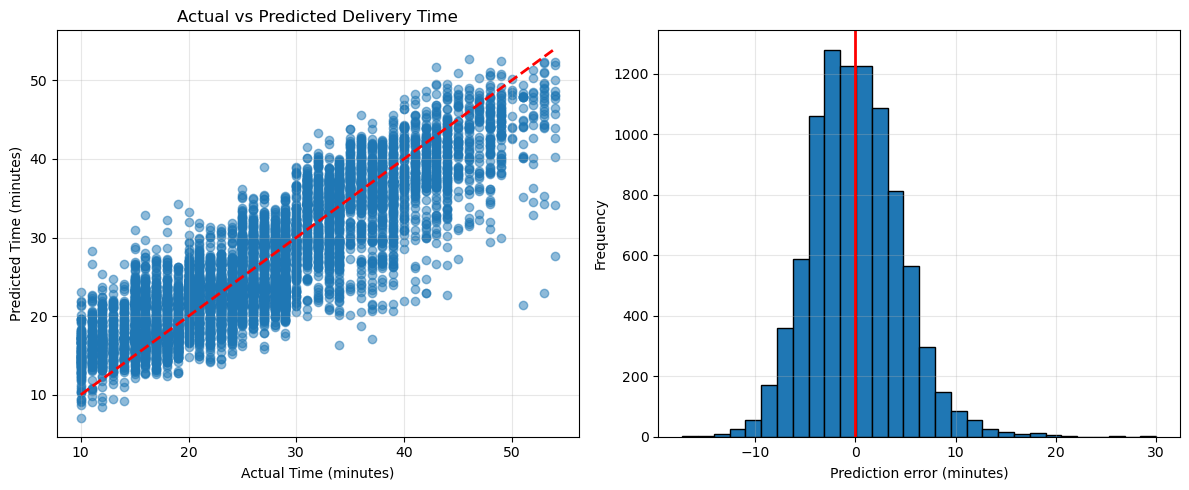

In [13]:
#visualizinf results
plt.figure(figsize=(12,5))

#plot1:actual vs predicted
plt.subplot(1,2,1)
plt.scatter(y_test,y_pred, alpha =0.5)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],'r--',lw=2)
plt.xlabel('Actual Time (minutes)')
plt.ylabel('Predicted Time (minutes)')
plt.title('Actual vs Predicted Delivery Time')
plt.grid(True,alpha =0.3)

#plot2 prediction errors
plt.subplot(1,2,2)
errors =y_test-y_pred
plt.hist(errors,bins=30,edgecolor = 'black')
plt.xlabel('Prediction error (minutes)')
plt.ylabel('Frequency')
plt.axvline(x=0,color='r',linestyle ='-',linewidth =2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
#The scatter plot shows predictions closely following the ideal diagonal line, while the residual distribution is centered around zero, indicating accurate and unbiased delivery time predictions.


 TOP 10 MOST IMPORTANT FEATURES :
   multiple_deliveries            0.2143
   Delivery_person_Ratings        0.1803
   Road_traffic_density_encoded   0.1389
   Weatherconditions_encoded      0.1182
   Festival_encoded               0.1098
   Delivery_person_Age            0.0538
   order_hour                     0.0525
   City_encoded                   0.0472
   delivery_distance_km           0.0452
   Type_of_vehicle_encoded        0.0293


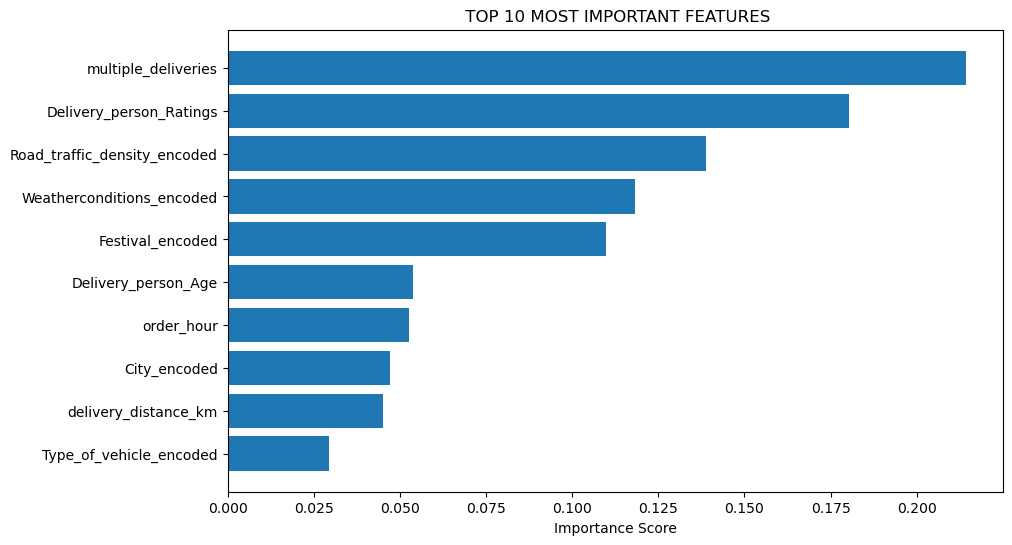

In [15]:
#feature_importance

importance_df =pd.DataFrame({
    'feature':features_columns,
    'importance':model.feature_importances_
    
}).sort_values('importance',ascending=False)

print("\n TOP 10 MOST IMPORTANT FEATURES :")
print("="*50)
for idx , row in importance_df.head(10).iterrows():
    print(f"   {row['feature']:30s} {row['importance']:.4f}")
print("="*50)



plt.figure(figsize=(10,6))
plt.barh(importance_df.head(10)['feature'],importance_df.head(10)['importance'])
plt.xlabel('Importance Score')
plt.title(" TOP 10 MOST IMPORTANT FEATURES")
plt.gca().invert_yaxis()
plt.show()

In [16]:
#make predictions
def predict_delivery_time(model, delivery_info):
    """ 
    predict delivery time for a new order 
    deliver_info: dict with all required features
    """
    input_df= pd.DataFrame([delivery_info])
    
    predicted_time =model.predict(input_df)[0]
    
    return predicted_time



In [17]:
example_delivery = {
    'Delivery_person_Age':28,
    'Delivery_person_Ratings':4.5,
    'Weatherconditions_encoded':2,
    'Road_traffic_density_encoded':1,
    'is_peak_hour':1,
    'is_weekend':0,
    'delivery_distance_km':6.5,
    'Type_of_order_encoded':1,
    'Type_of_vehicle_encoded':0,
    'Festival_encoded':0,
    'City_encoded':1,
    'multiple_deliveries':1,
    'order_hour':19,
}

predicted_time = predict_delivery_time(model, example_delivery)
print(f"\n🍕 Predicted Delivery Time: {predicted_time:.1f} minutes")


🍕 Predicted Delivery Time: 26.7 minutes


In [18]:
%%writefile app.py

import streamlit as st
import pandas as pd
import joblib
from datetime import datetime
import os

# ===================== PAGE CONFIG =====================
st.set_page_config(
    page_title="🍔 Delivery Time Predictor",
    page_icon="🍔",
    layout="wide"
)

# ===================== STYLES =====================
st.markdown("""
<style>
.main-header {
    font-size: 3rem;
    color: #FF4B4B;
    text-align: center;
    margin-bottom: 2rem;
}
.prediction-box {
    background-color: #f0f2f6;
    padding: 2rem;
    border-radius: 10px;
    text-align: center;
    font-size: 2rem;
    font-weight: bold;
    color: #FF4B4B;
}
.help-box {
    background-color: #e3f2fd;
    padding: 1rem;
    border-radius: 5px;
    border-left: 4px solid #2196F3;
    margin: 1rem 0;
}
</style>
""", unsafe_allow_html=True)

# ===================== TITLE =====================
st.markdown('<h1 class="main-header">🍔 Food Delivery Time Predictor</h1>', unsafe_allow_html=True)
st.markdown("### Powered by XGBoost Machine Learning 🤖")

# ===================== LOAD MODEL =====================
@st.cache_resource
def load_model():
    try:
        model = joblib.load("delivery_time_model.pkl")
        encoders = joblib.load("label_encoders.pkl")
        return model, encoders
    except Exception as e:
        st.error("❌ Model files not found or failed to load.")
        st.code(str(e))
        st.stop()

model, label_encoders = load_model()

# ===================== PRESETS =====================
if "preset" not in st.session_state:
    st.session_state.preset = "urban_lunch"

presets = {
    "urban_lunch": dict(distance=5.2, age=28, rating=4.5, multiple=2, hour=13, weekend=False),
    "late_night": dict(distance=3.1, age=25, rating=4.7, multiple=0, hour=23, weekend=True),
    "weekend_dinner": dict(distance=7.8, age=32, rating=4.3, multiple=1, hour=20, weekend=True)
}

preset = presets[st.session_state.preset]

# ===================== QUICK BUTTONS =====================
st.markdown("### 🎯 Quick Start Examples")
c1, c2, c3 = st.columns(3)
if c1.button("🏙️ Urban Lunch"): st.session_state.preset = "urban_lunch"
if c2.button("🌃 Late Night"): st.session_state.preset = "late_night"
if c3.button("🏡 Weekend Dinner"): st.session_state.preset = "weekend_dinner"

st.divider()

# ===================== INPUTS =====================
col1, col2 = st.columns([2, 1])

with col1:
    st.subheader("📝 Enter Details")

    distance = st.number_input("📍 Distance (km)", 0.1, 50.0, preset["distance"], 0.1)
    order_hour = st.slider("🕐 Order Hour", 0, 23, preset["hour"])
    is_peak = int(11 <= order_hour <= 14 or 18 <= order_hour <= 22)
    is_weekend = st.checkbox("📅 Weekend", preset["weekend"])

    age = st.slider("👤 Delivery Age", 18, 60, preset["age"])
    rating = st.slider("⭐ Rating", 1.0, 5.0, preset["rating"], 0.1)
    multiple = st.selectbox("📦 Multiple Deliveries", [0, 1, 2, 3], preset["multiple"])

    weather = st.selectbox("🌦 Weather", list(label_encoders["Weatherconditions"].classes_))
    traffic = st.selectbox("🚦 Traffic", list(label_encoders["Road_traffic_density"].classes_))
    order_type = st.selectbox("🍽 Order Type", list(label_encoders["Type_of_order"].classes_))
    vehicle = st.selectbox("🛵 Vehicle", list(label_encoders["Type_of_vehicle"].classes_))
    city = st.selectbox("🏙 City", list(label_encoders["City"].classes_))
    festival = st.selectbox("🎊 Festival", list(label_encoders["Festival"].classes_))

# ===================== INFO PANEL =====================
with col2:
    st.subheader("📊 Quick Info")

    st.success("🔥 Peak Hour" if is_peak else "✅ Off Peak")

    traffic_emoji = {"Low": "🟢", "Medium": "🟡", "High": "🟠", "Jam": "🔴"}
    st.info(f"🚦 {traffic_emoji.get(traffic, '⚪')} {traffic}")

# ===================== PREDICTION =====================
st.divider()

if st.button("🔮 Predict Delivery Time", type="primary", use_container_width=True):
    try:
        input_df = pd.DataFrame([{
            "Delivery_person_Age": age,
            "Delivery_person_Ratings": rating,
            "Weatherconditions_encoded": label_encoders["Weatherconditions"].transform([weather])[0],
            "Road_traffic_density_encoded": label_encoders["Road_traffic_density"].transform([traffic])[0],
            "is_peak_hour": is_peak,
            "is_weekend": int(is_weekend),
            "delivery_distance_km": distance,
            "Type_of_order_encoded": label_encoders["Type_of_order"].transform([order_type])[0],
            "Type_of_vehicle_encoded": label_encoders["Type_of_vehicle"].transform([vehicle])[0],
            "Festival_encoded": label_encoders["Festival"].transform([festival])[0],
            "City_encoded": label_encoders["City"].transform([city])[0],
            "multiple_deliveries": multiple,
            "order_hour": order_hour
        }])

        prediction = model.predict(input_df)[0]

        st.balloons()
        st.markdown(f"<div class='prediction-box'>⏱ {prediction:.0f} minutes</div>", unsafe_allow_html=True)

        arrival = datetime.now() + pd.to_timedelta(prediction, unit="m")
        st.info(f"🕐 Estimated Arrival: {arrival.strftime('%I:%M %p')}")

    except Exception as e:
        st.error("Prediction failed")
        st.code(str(e))

# ===================== FOOTER =====================
st.divider()
st.markdown(
    "<center>🤖 XGBoost ML Model • Built with Streamlit</center>",
    unsafe_allow_html=True
)


Overwriting app.py


In [ ]:
!streamlit run app.py
